<a href="https://colab.research.google.com/github/CPeti/Spot-price-prediction/blob/peter-dev/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import zscore
from scipy.signal import periodogram, find_peaks, detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot, lag_plot

# Visual analysis

In [2]:
data = pd.read_csv('./data/data_NO2.csv', sep=';')
data.head()

,datetime_utc,volume_demand,volume_production,spot_price
0,2015-12-31 23:00:00+00:00,4043.0,7818.0,16.39
1,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04
2,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74
3,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57
4,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47


In [3]:
data.describe()

,volume_demand,volume_production,spot_price
count,23666.000000,23666.000000,23666.000000
mean,4026.109186,5861.271867,30.891299
std,800.387150,1903.453922,9.601914
min,2490.000000,1082.000000,2.890000
25%,3373.000000,4449.000000,24.180000
50%,3875.000000,5605.000000,29.110000
75%,4648.000000,7411.750000,34.710000
max,6712.000000,9953.000000,114.700000


## Check for missing values

In [4]:
# count the number of missing values in each column
missing_values = data.isnull().sum()
missing_values

datetime_utc         0
volume_demand        0
volume_production    0
spot_price           0
dtype: int64

## Features

In [5]:
# add calendar features
data['date'] = pd.to_datetime(data['datetime_utc'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek

data = data.drop(columns=['datetime_utc'])

In [6]:
# additional time features
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x > 4 else 0)
data['working_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 17 else 0)
data['night'] = data['hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)
data['morning'] = data['hour'].apply(lambda x: 1 if 7 <= x <= 11 else 0)
data['afternoon'] = data['hour'].apply(lambda x: 1 if 12 <= x <= 16 else 0)
data['evening'] = data['hour'].apply(lambda x: 1 if 17 <= x <= 23 else 0)


In [7]:
# production and demand features
data['delta'] = data['volume_production'] - data['volume_demand']

# create a feature where we sum the previous days production values
data['volume_production_rolling'] = data['volume_production'].rolling(window=48).sum()
data['volume_demand_rolling'] = data['volume_demand'].rolling(window=48).sum()




In [8]:
# shift spot_price by 24 hours as target
data['target'] = data['spot_price'].shift(-24)

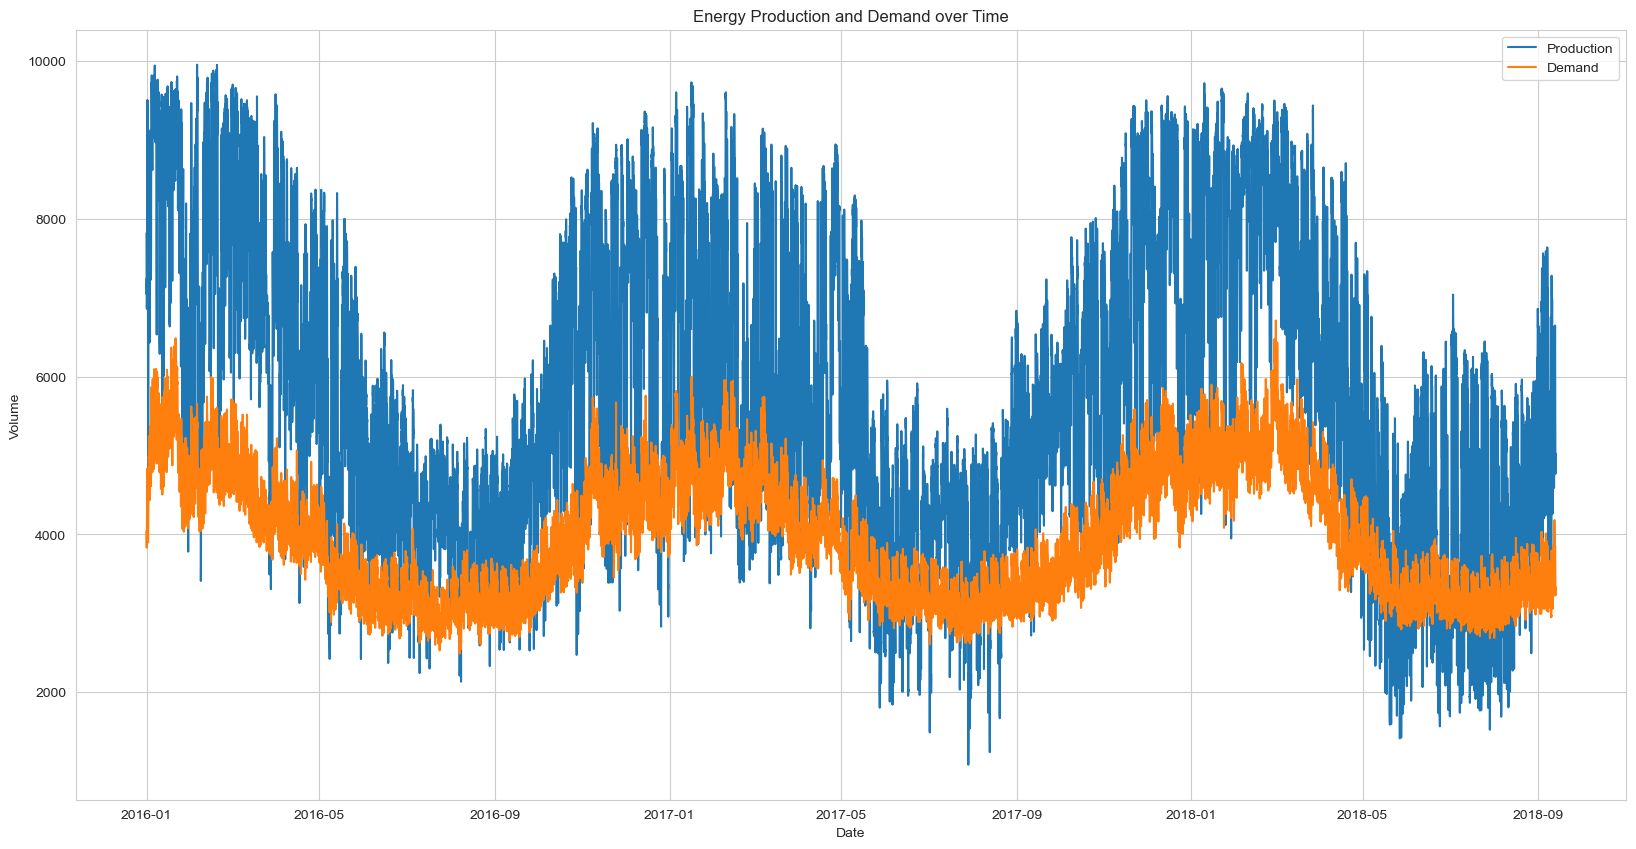

In [9]:
# plot production and demand
plt.figure(figsize=(20, 10))
plt.plot(data['date'], data['volume_production'], label='Production')
plt.plot(data['date'], data['volume_demand'], label='Demand')
plt.legend()
plt.title('Energy Production and Demand over Time')
plt.xlabel('Date')
plt.ylabel('Volume') # TODO: add units
plt.show()

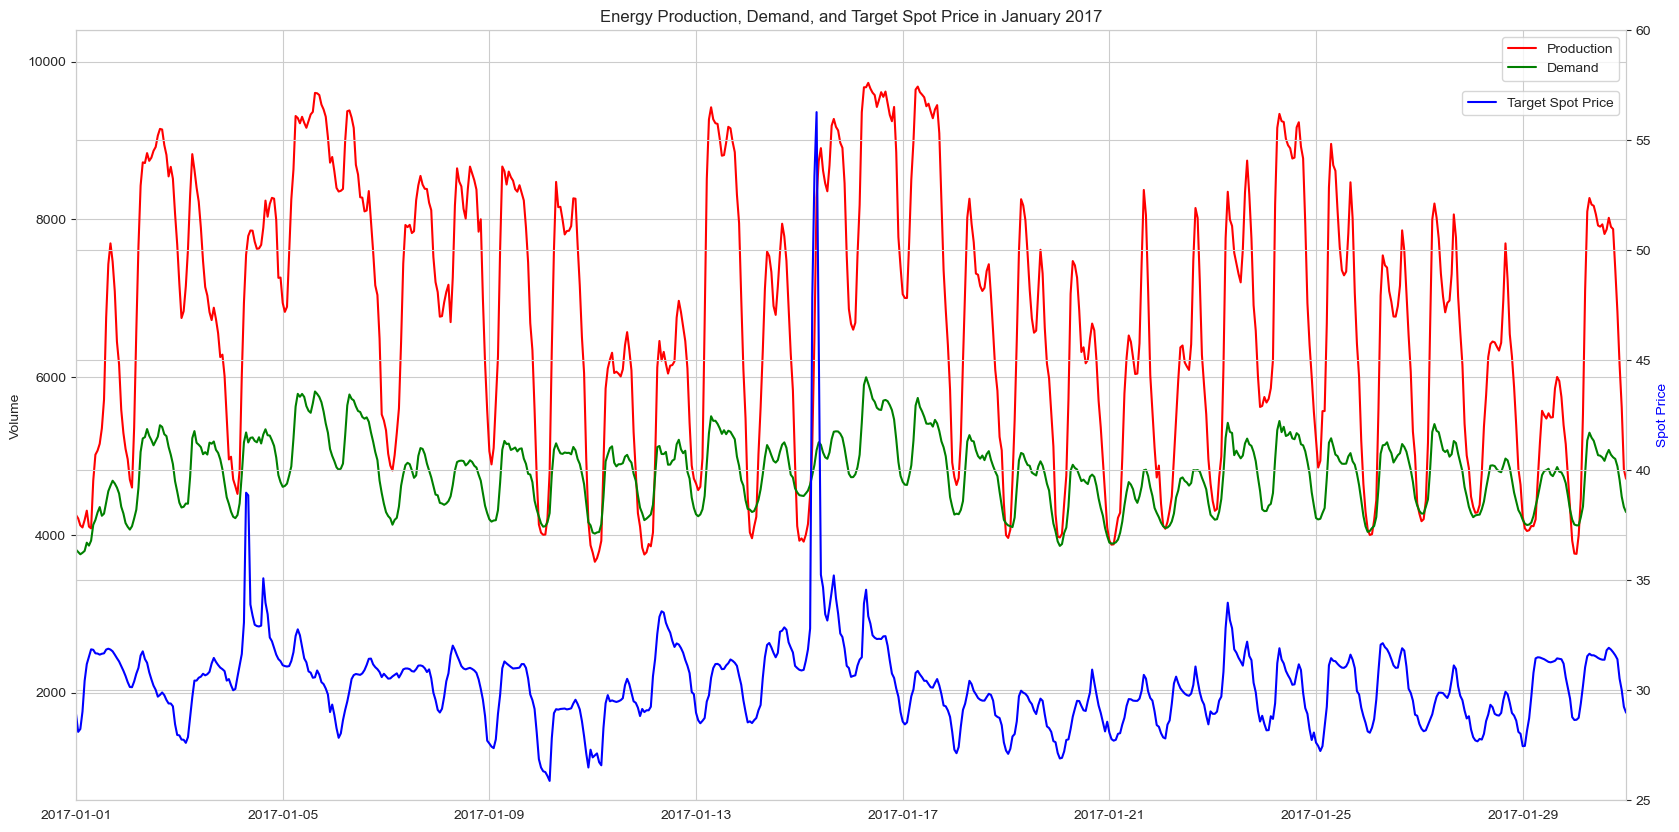

In [10]:
_, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.plot(data['date'], data['volume_production'], 'r-', label='Production')
ax1.plot(data['date'], data['volume_demand'], 'g-', label='Demand')
ax2.plot(data['date'], data['target'], 'b-', label='Target Spot Price')
ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))
ax2.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-01-31'))
ax2.set_ylim(25, 60)

plt.xlabel('Date')
ax1.set_ylabel('Volume') # TODO: add units
ax2.set_ylabel('Spot Price', color='b')
ax1.legend()
ax2.legend(bbox_to_anchor=(1, 0.93))
plt.title('Energy Production, Demand, and Target Spot Price in January 2017')
plt.show()

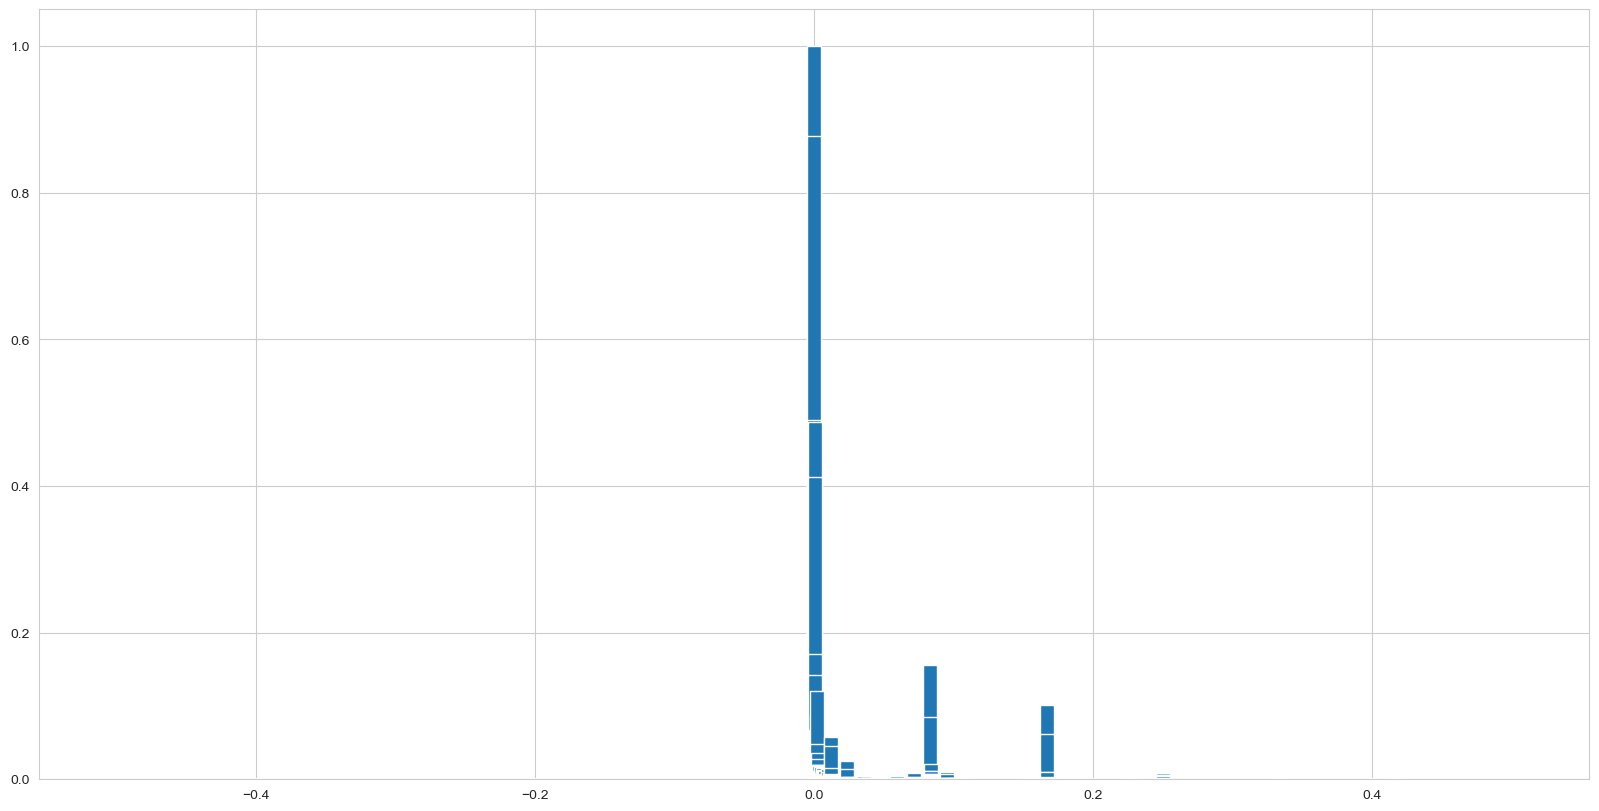

In [11]:
prices = data['spot_price']
prices = prices - prices.mean()
prices = detrend(prices)
prices = np.pad(prices, (0, 2 ** 16 - prices.shape[0]), 'constant')

sample_size = prices.shape[0]

FF = np.abs(np.fft.fft(prices) / sample_size) ** 2
P = (4 / sample_size) * FF[0:sample_size // 2]
f = np.fft.fftfreq(sample_size//2, 1)
P = P[1:] / P[1:].max()
peaks, _ = find_peaks(P, prominence=(0.004, 20.6), distance=20)

# TODO: this requires explanation
plt.figure(figsize=(20, 10))
plt.bar(f[1:], P, width=0.01)
plt.show()

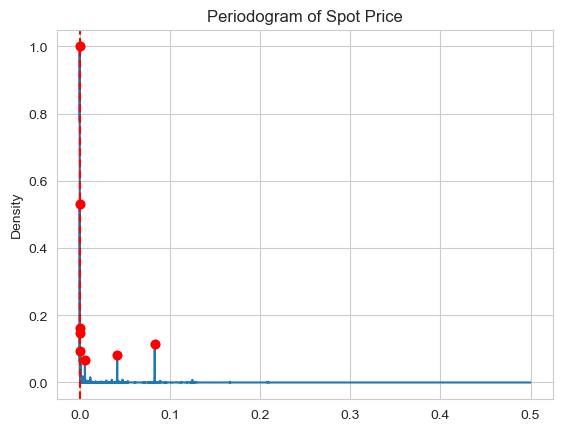

In [12]:
# create a periodogram
detrended_prices = detrend(data['spot_price'])
padded_prices = np.pad(detrended_prices, (0, 2000), 'constant')
f, Pxx = periodogram(padded_prices, fs=1, detrend=False)
periods = f[1:]
density = Pxx[1:] / Pxx[1:].max()
max_density_index = density.argmax()

period = periods[max_density_index]
peaks, _ = find_peaks(density, prominence=0.05)

plt.plot(periods, density)
plt.plot(periods[peaks], density[peaks], 'ro')
plt.plot(periods[peaks], density[peaks], 'ro')
plt.axvline(period, color='red', linestyle='--')
plt.title('Periodogram of Spot Price')
plt.ylabel('Density')
plt.show()

In [13]:
# create a list of (period, density) tuples for the peaks
peaks_tuple = [(np.round(1/periods[i])/24, density[peak]) for peak, i in enumerate(peaks)]
peaks_tuple.sort(key=lambda x: x[1], reverse=True)

for peak in peaks_tuple:
    print(f'{peak[0].round(4)} days: {peak[1].round(4)} density')

213.875 days: 1.0 density
534.7083 days: 0.7775 density
1.0 days: 0.5305 density
48.625 days: 0.1469 density
0.5 days: 0.1308 density
97.2083 days: 0.1029 density
152.7917 days: 0.0854 density
7.0 days: 0.0603 density


# Univariate analysis

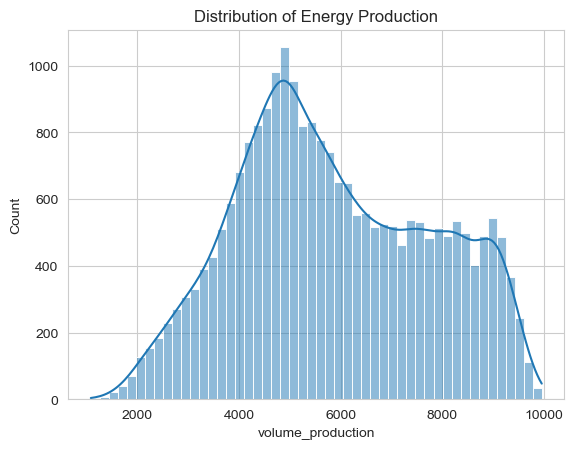

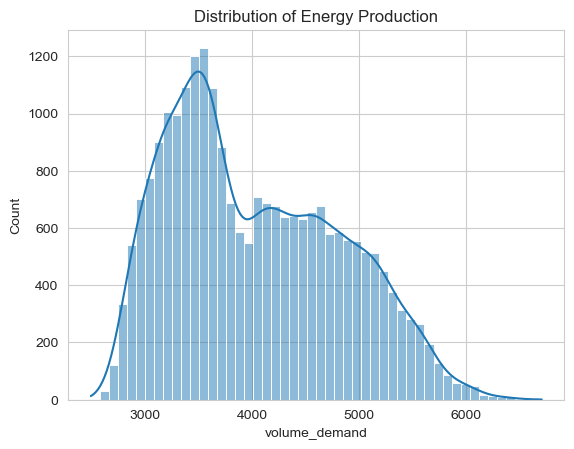

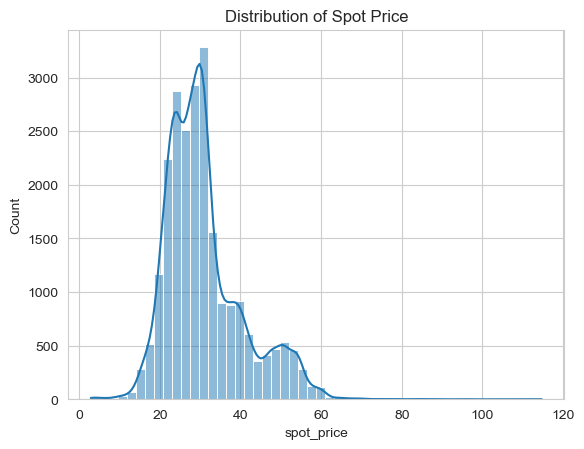

In [14]:
sns.histplot(data['volume_production'], bins=50, kde=True)
plt.title('Distribution of Energy Production')
plt.show()

sns.histplot(data['volume_demand'], bins=50, kde=True)
plt.title('Distribution of Energy Production')
plt.show()

sns.histplot(data['spot_price'], bins=50, kde=True)
plt.title('Distribution of Spot Price')
plt.show()

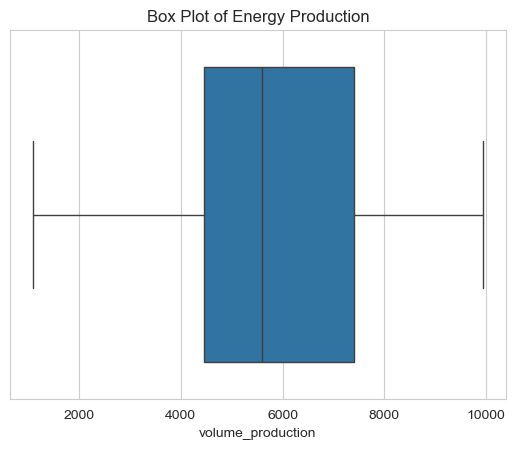

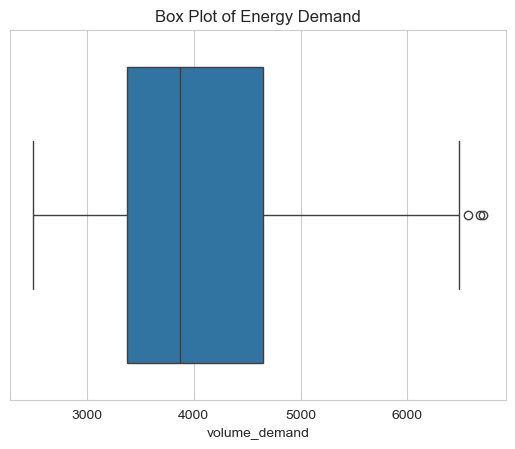

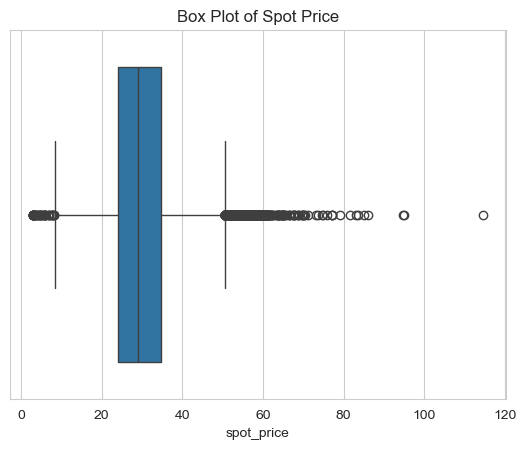

In [15]:
sns.boxplot(x=data['volume_production'])
plt.title('Box Plot of Energy Production')
plt.show()

sns.boxplot(x=data['volume_demand'])
plt.title('Box Plot of Energy Demand')
plt.show()

sns.boxplot(x=data['spot_price'])
plt.title('Box Plot of Spot Price')
plt.show()


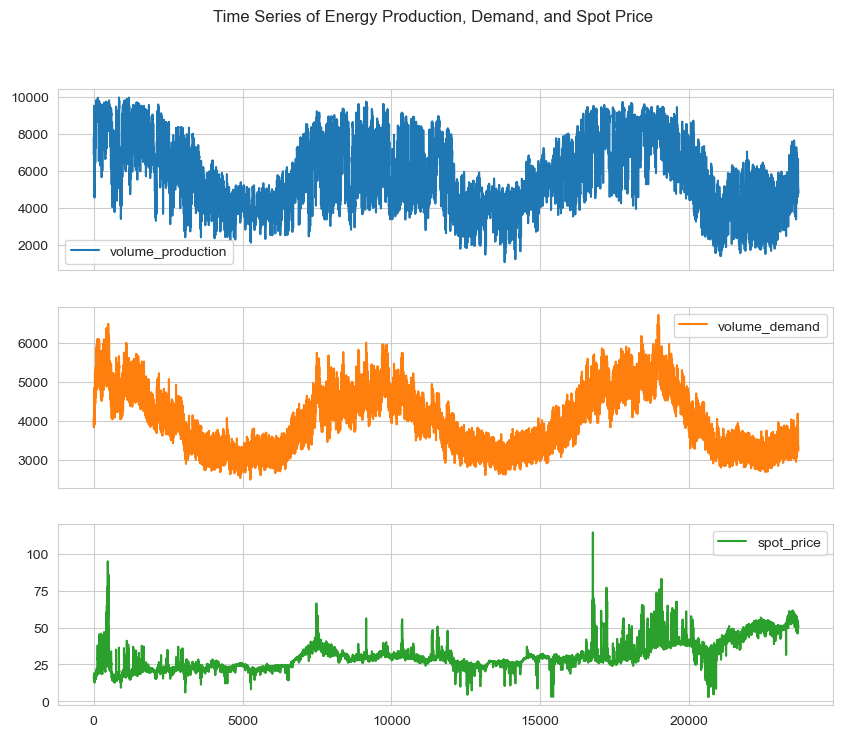

In [16]:
data[['volume_production', 'volume_demand', 'spot_price']].plot(subplots=True, figsize=(10, 8), title='Time Series of Energy Production, Demand, and Spot Price')
plt.show()

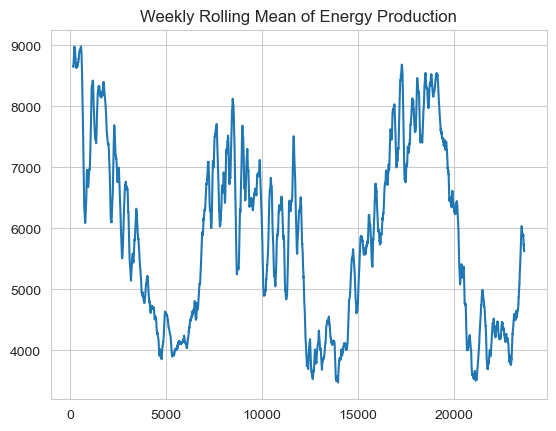

In [17]:
data['rolling_mean_production'] = data['volume_production'].rolling(window=24*7).mean()  # 24-hour window
data['rolling_mean_production'].plot()
plt.title('Weekly Rolling Mean of Energy Production')
plt.show()

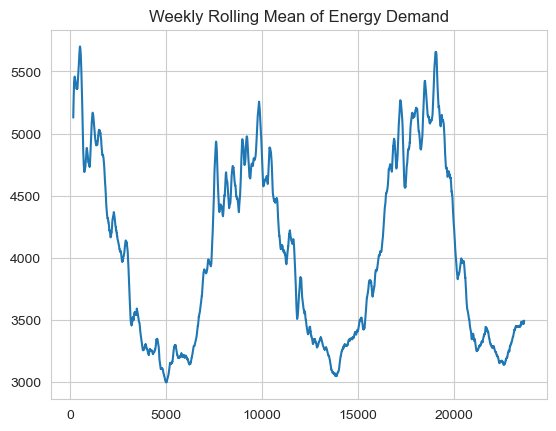

In [18]:
data['rolling_mean_demand'] = data['volume_demand'].rolling(window=24*7).mean()  # 24-hour window
data['rolling_mean_demand'].plot()
plt.title('Weekly Rolling Mean of Energy Demand')
plt.show()

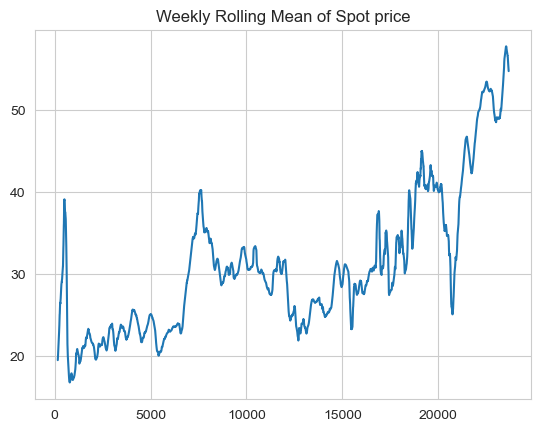

In [19]:
data['rolling_mean_spot_price'] = data['spot_price'].rolling(window=24*7).mean()  # 24-hour window
data['rolling_mean_spot_price'].plot()
plt.title('Weekly Rolling Mean of Spot price')
plt.show()

# Bivariate analysis

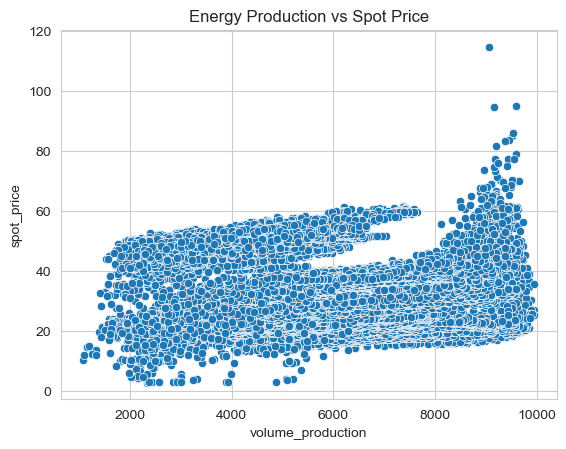

In [20]:
sns.scatterplot(x='volume_production', y='spot_price', data=data)
plt.title('Energy Production vs Spot Price')
plt.show()


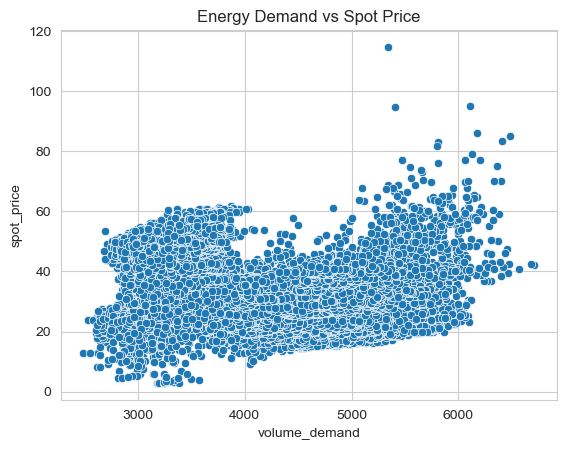

In [21]:
sns.scatterplot(x='volume_demand', y='spot_price', data=data)
plt.title('Energy Demand vs Spot Price')
plt.show()

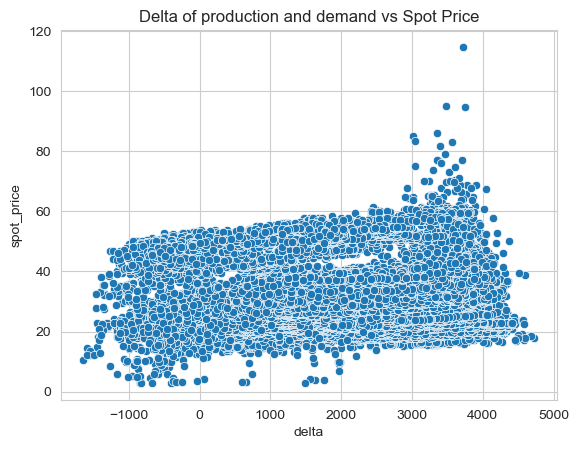

In [22]:
sns.scatterplot(x='delta', y='spot_price', data=data)
plt.title('Delta of production and demand vs Spot Price')
plt.show()

# Time series decomposition

i dont actually know what these do

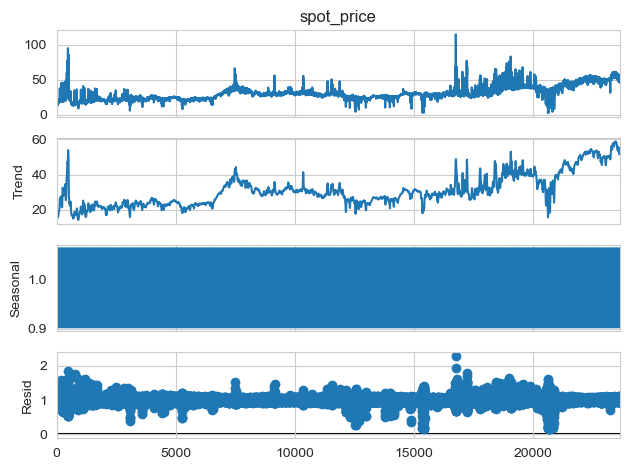

In [23]:
decomposition = seasonal_decompose(data['spot_price'], model='multiplicative', period=24)
decomposition.plot()
plt.show()

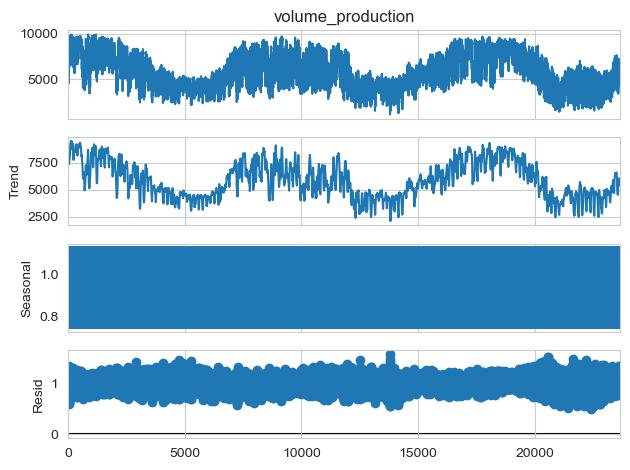

In [24]:
decomposition = seasonal_decompose(data['volume_production'], model='multiplicative', period=24)
decomposition.plot()
plt.show()

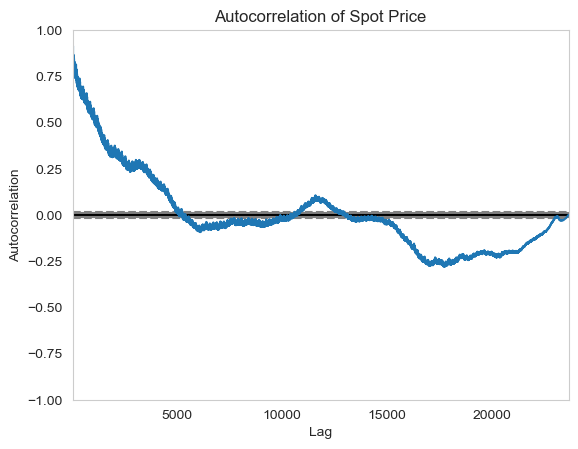

In [25]:
autocorrelation_plot(data['spot_price'])
plt.title('Autocorrelation of Spot Price')
plt.show()

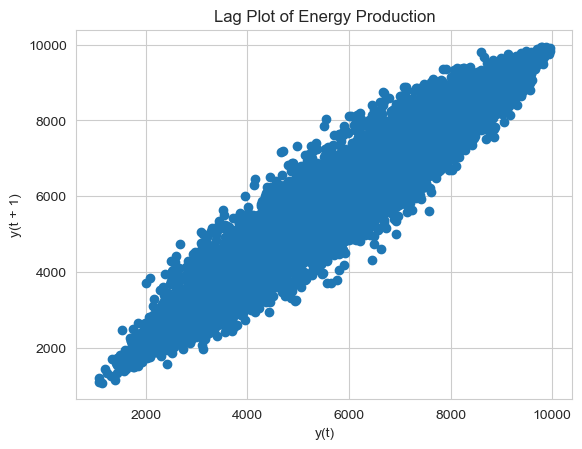

In [26]:
lag_plot(data['volume_production'])
plt.title('Lag Plot of Energy Production')
plt.show()

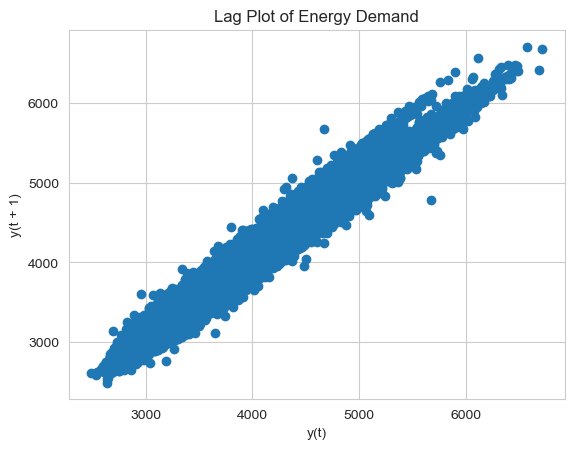

In [27]:
lag_plot(data['volume_demand'])
plt.title('Lag Plot of Energy Demand')
plt.show()


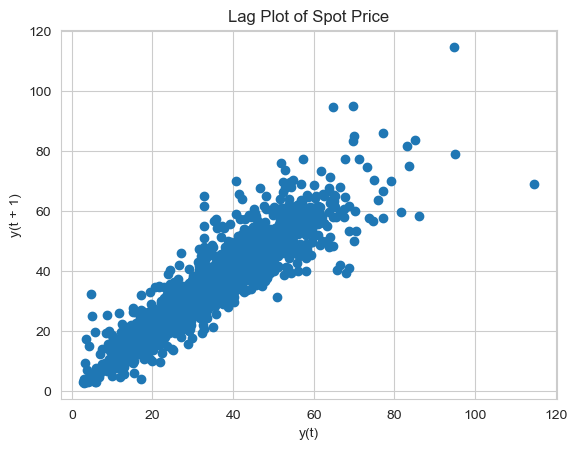

In [28]:
from pandas.plotting import lag_plot
lag_plot(data['spot_price'])
plt.title('Lag Plot of Spot Price')
plt.show()

In [29]:
# TODO: clean corr matrix
# check correlation between features and target
data_ = data.drop(columns=['spot_price'])
correlation = data_.corr()
correlation['target'].sort_values(ascending=False)

target                       1.000000
rolling_mean_spot_price      0.877033
date                         0.700841
year                         0.666659
volume_production            0.101399
volume_demand                0.099505
working_hours                0.094767
delta                        0.087912
month                        0.081791
morning                      0.079679
week                         0.070881
hour                         0.046832
afternoon                    0.039247
volume_demand_rolling        0.031718
rolling_mean_demand          0.026872
volume_production_rolling   -0.002349
evening                     -0.006977
day                         -0.007680
rolling_mean_production     -0.015257
weekend                     -0.041984
dayofweek                   -0.054476
night                       -0.099276
Name: target, dtype: float64

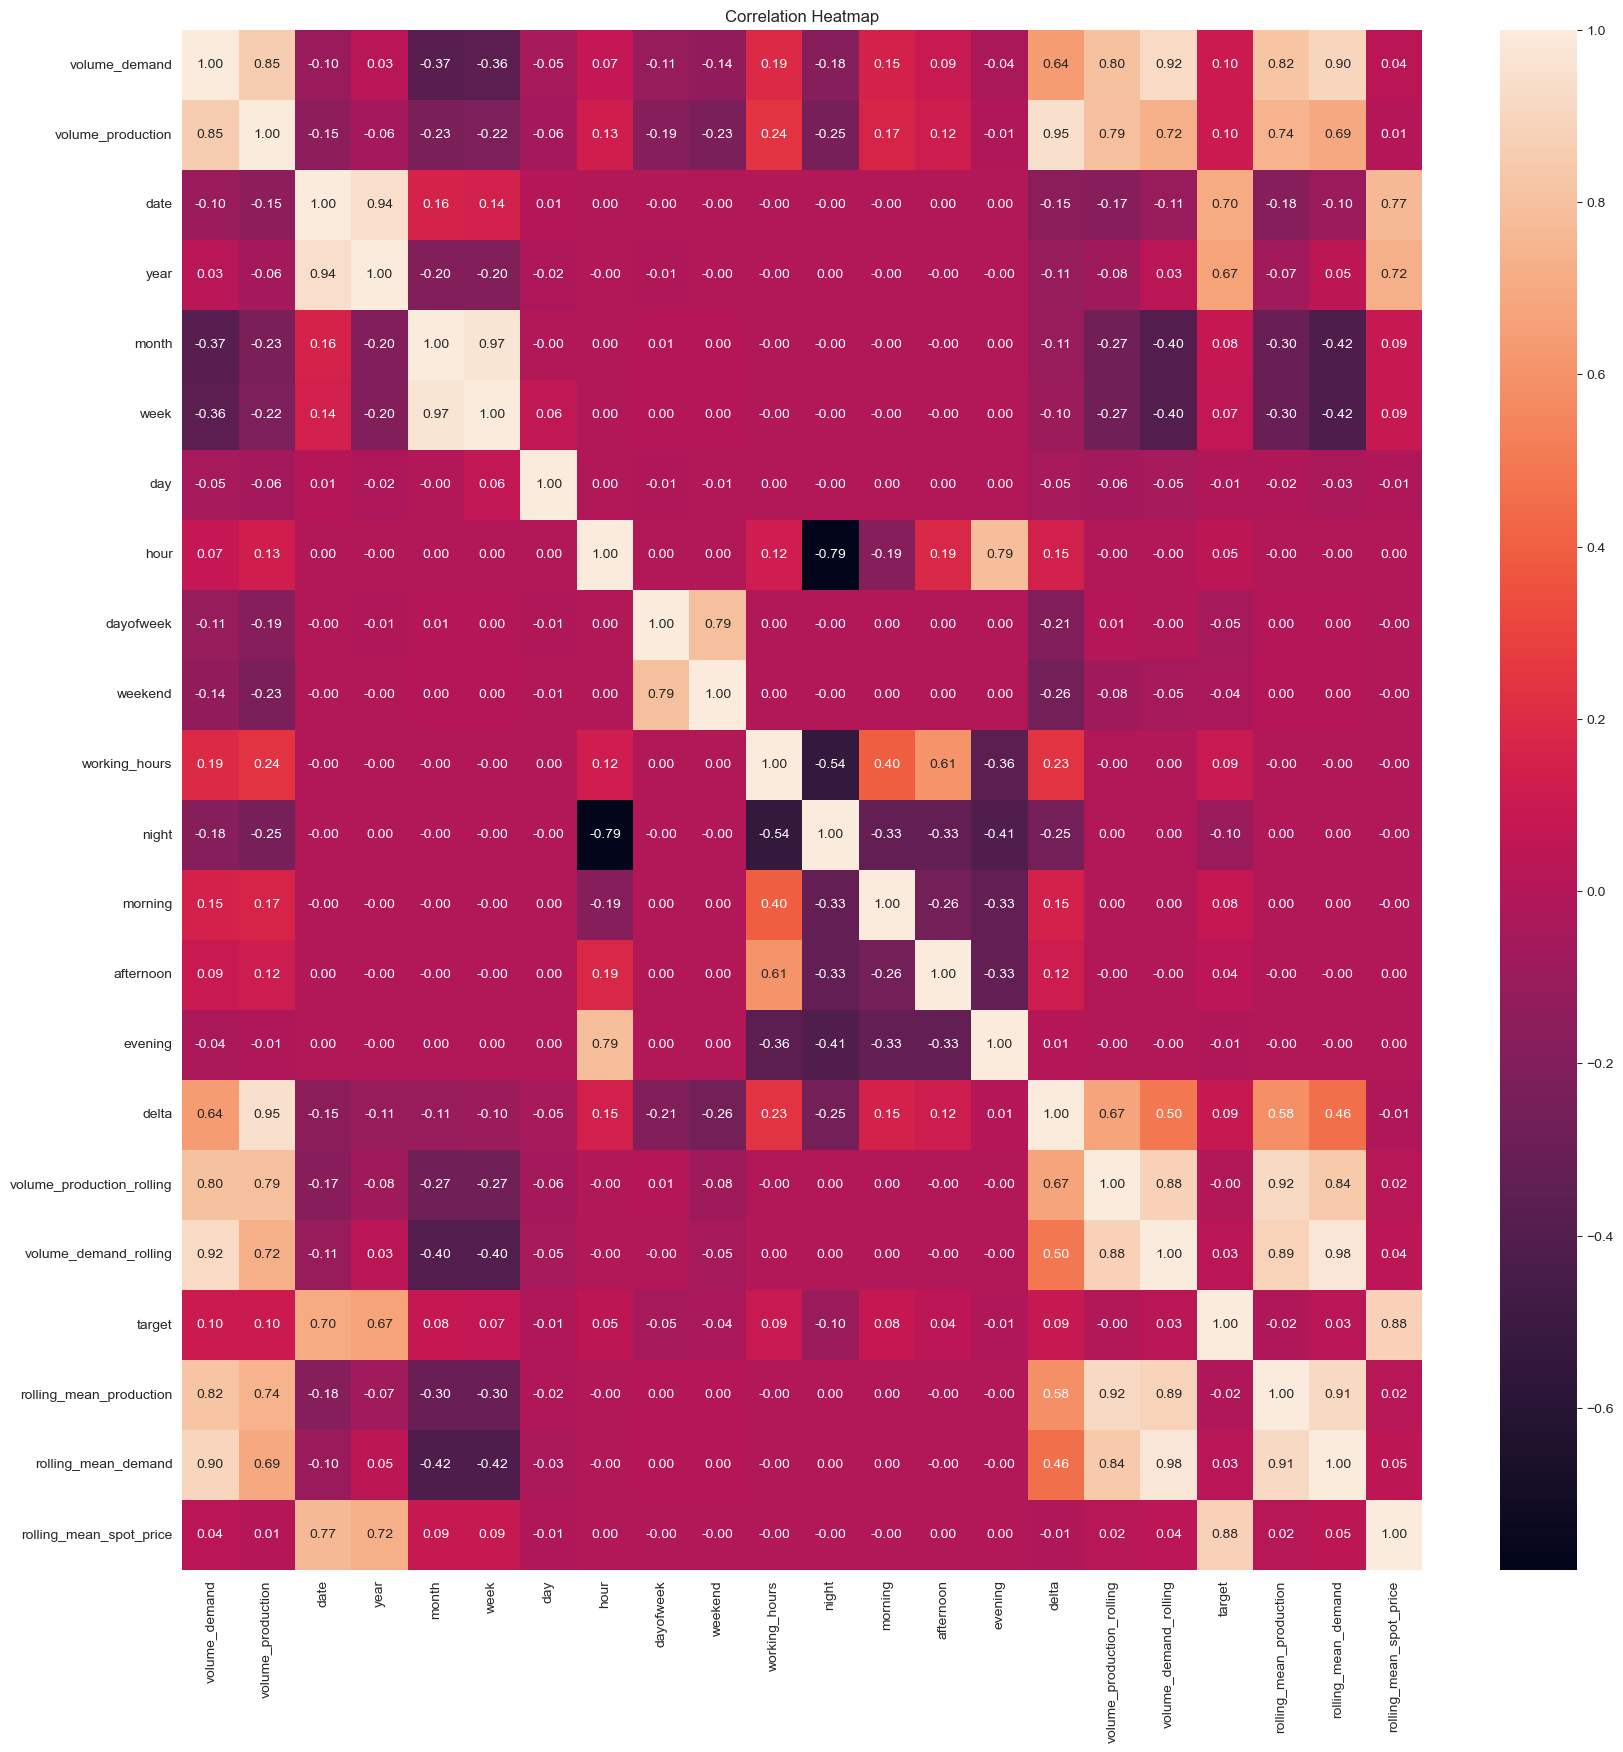

In [30]:
# correlation heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Peaks

In [31]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [32]:
data.set_index('date', inplace=True)

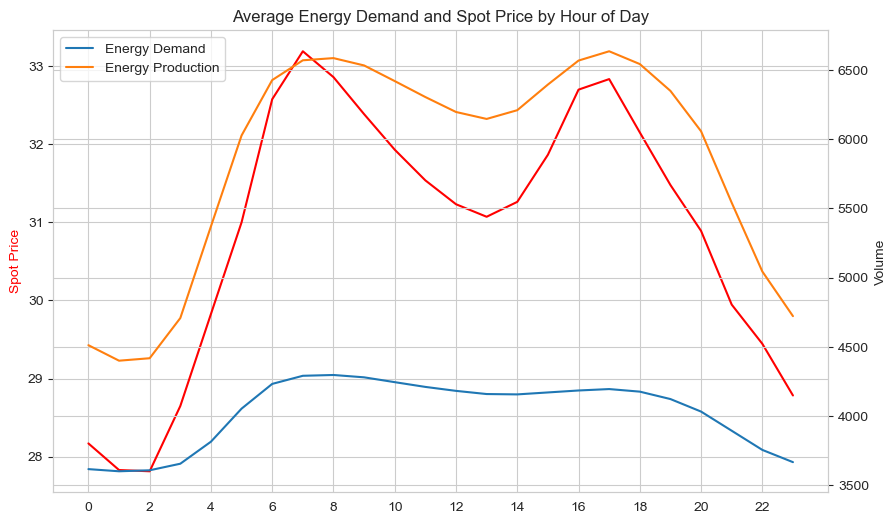

In [33]:
data['hour'] = data.index.hour
hourly_avg = data.groupby('hour').mean(numeric_only=True)
_, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(hourly_avg['spot_price'], color='red')
ax2.plot(hourly_avg[['volume_demand', 'volume_production']])
# legend
ax2.legend(['Energy Demand', 'Energy Production'])
# set labels
ax.set_ylabel('Spot Price', color='red')
ax2.set_ylabel('Volume')
plt.title('Average Energy Demand and Spot Price by Hour of Day')
plt.xticks(range(0, 24, 2))
plt.xlabel('Hour')
plt.show()

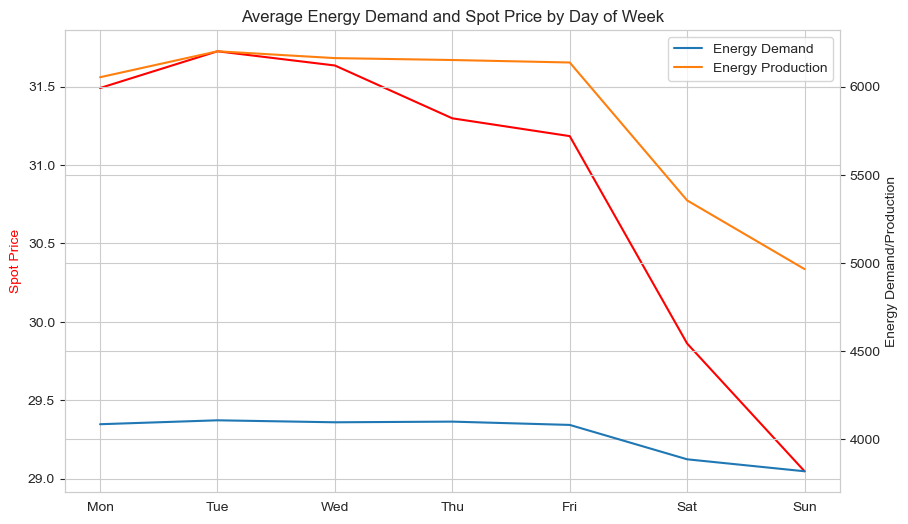

In [34]:
weekly_data = data
weekly_data['day_of_week'] = data.index.dayofweek
daily_avg = weekly_data.groupby('dayofweek').mean(numeric_only=True)
_, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(daily_avg['spot_price'], color='red')
ax2.plot(daily_avg[['volume_demand', 'volume_production']])
# legend
ax2.legend(['Energy Demand', 'Energy Production'])
# set labels
ax.set_ylabel('Spot Price', color='red')
ax2.set_ylabel('Energy Demand/Production')
plt.title('Average Energy Demand and Spot Price by Day of Week')
plt.xticks(range(7), labels=days)
plt.show()

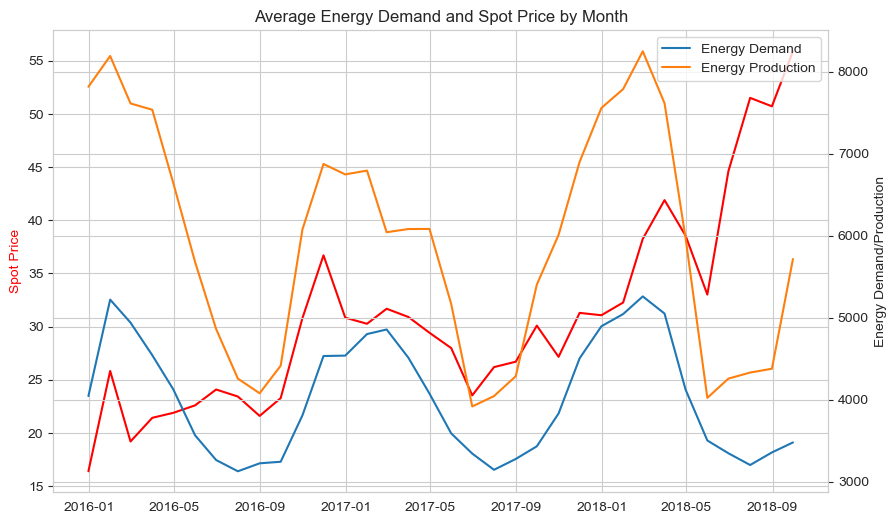

In [35]:
# monthly averages
monthly_avg = data.resample('ME').mean(numeric_only=True)
_, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
ax.plot(monthly_avg['spot_price'], color='red')
ax2.plot(monthly_avg[['volume_demand', 'volume_production']])
# legend
ax2.legend(['Energy Demand', 'Energy Production'])
# set labels
ax.set_ylabel('Spot Price', color='red')
ax2.set_ylabel('Energy Demand/Production')
plt.title('Average Energy Demand and Spot Price by Month')
plt.show()

In [36]:
effects = ['volume_demand', 'volume_production', 'spot_price']
week_colors = cm.jet(np.linspace(0, 1, 7))

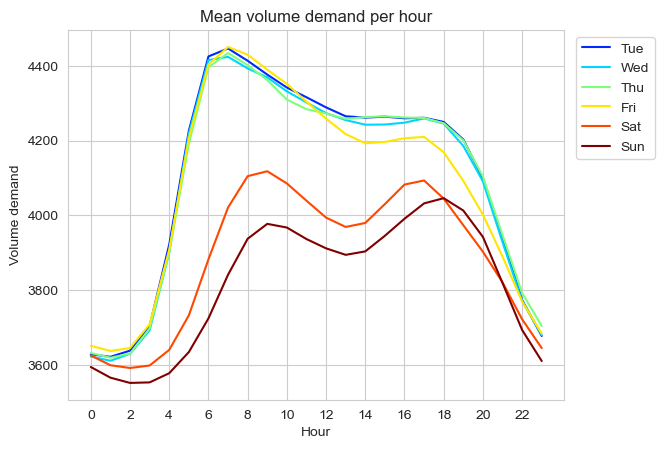

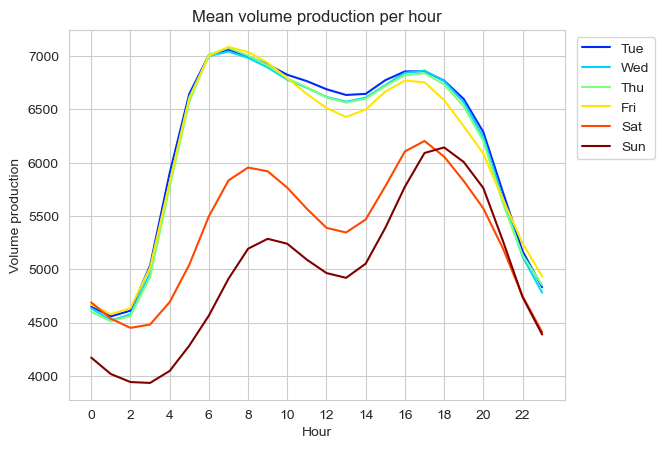

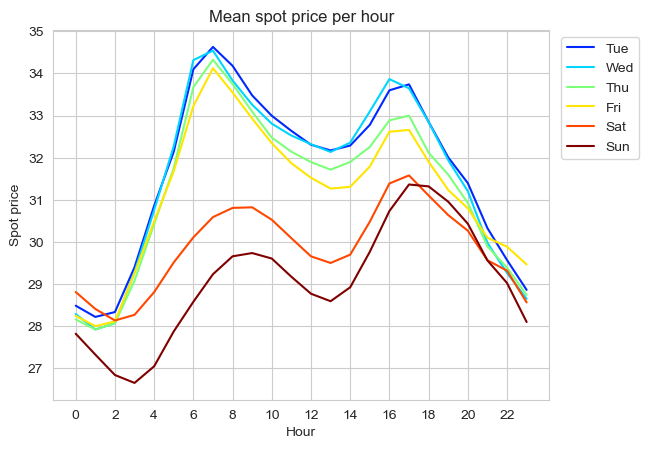

In [37]:
groups = ['dayofweek', 'hour']
hourly_data = data[effects + groups].groupby(groups).mean()
for var in effects:
    for i in range(1, 7):
        plt.plot(hourly_data.loc[i][var], color=week_colors[i], label=days[i])

    pretty_name = var.replace('_', ' ')
    plt.title(f'Mean {pretty_name} per hour')
    plt.xlabel("Hour")
    plt.xticks(range(0, 24, 2))
    plt.ylabel(pretty_name.capitalize())
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

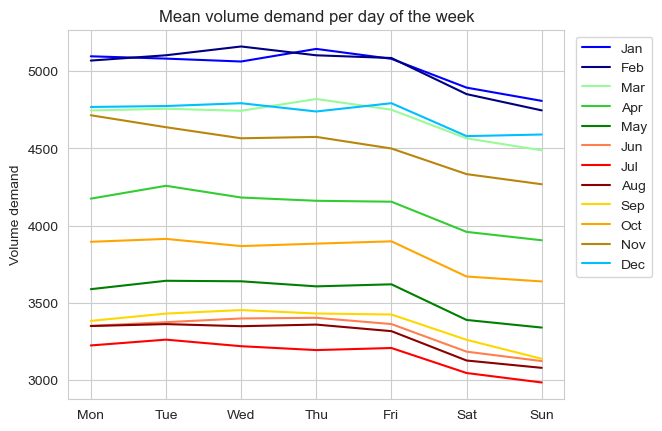

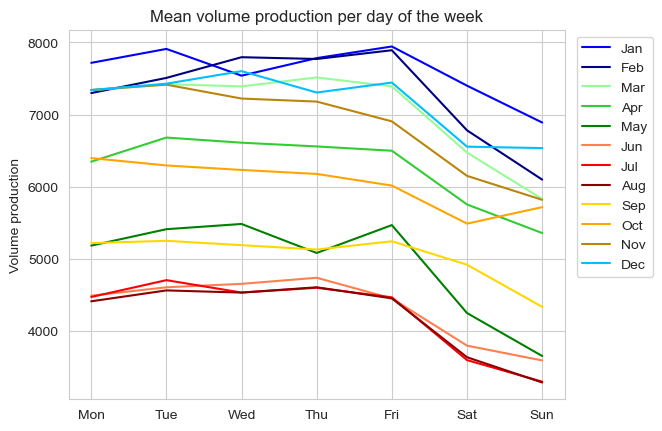

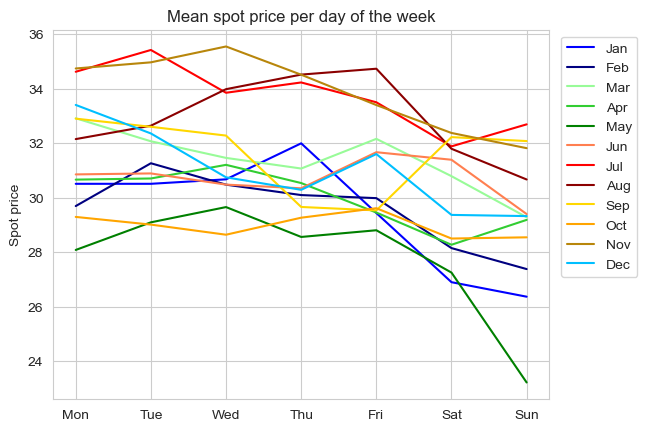

In [38]:
groups = ['month', 'dayofweek']
weekly_data = data[effects + groups].groupby(groups).mean()
for var in effects:
    plt.plot(weekly_data.loc[1][var], label='Jan', color='blue')
    plt.plot(weekly_data.loc[2][var], label='Feb', color='navy')
    plt.plot(weekly_data.loc[3][var], label='Mar', color='palegreen')
    plt.plot(weekly_data.loc[4][var], label='Apr', color='limegreen')
    plt.plot(weekly_data.loc[5][var], label='May', color='green')
    plt.plot(weekly_data.loc[6][var], label='Jun', color='coral')
    plt.plot(weekly_data.loc[7][var], label='Jul', color='red')
    plt.plot(weekly_data.loc[8][var], label='Aug', color='darkred')
    plt.plot(weekly_data.loc[9][var], label='Sep', color='gold')
    plt.plot(weekly_data.loc[10][var], label='Oct', color='orange')
    plt.plot(weekly_data.loc[11][var], label='Nov', color='darkgoldenrod')
    plt.plot(weekly_data.loc[12][var], label='Dec', color='deepskyblue')

    pretty_name = var.replace('_', ' ')
    plt.title(f'Mean {pretty_name} per day of the week')
    plt.xticks(range(7), labels=days)
    plt.ylabel(pretty_name.capitalize())
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

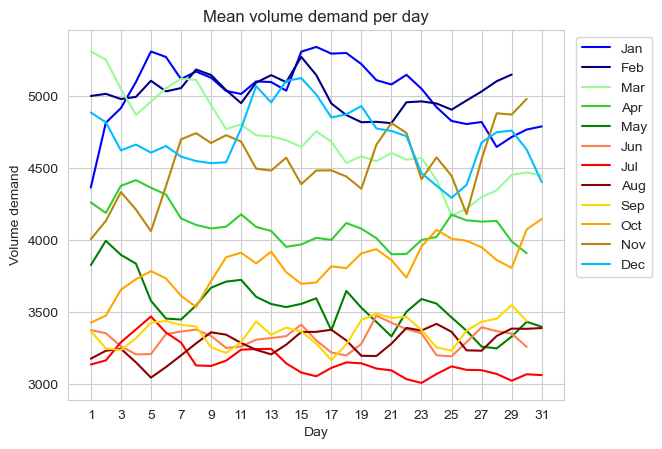

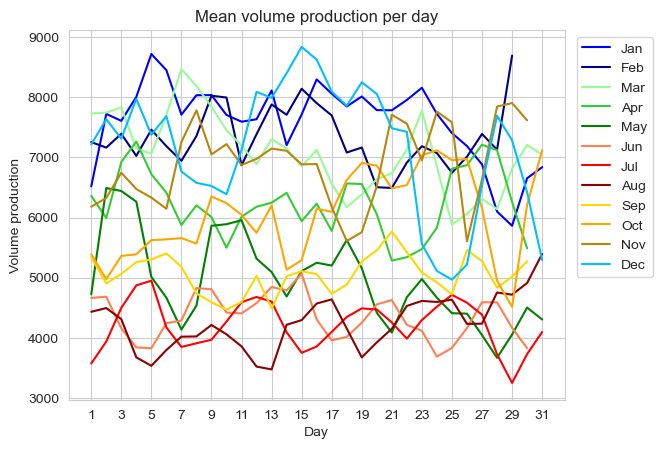

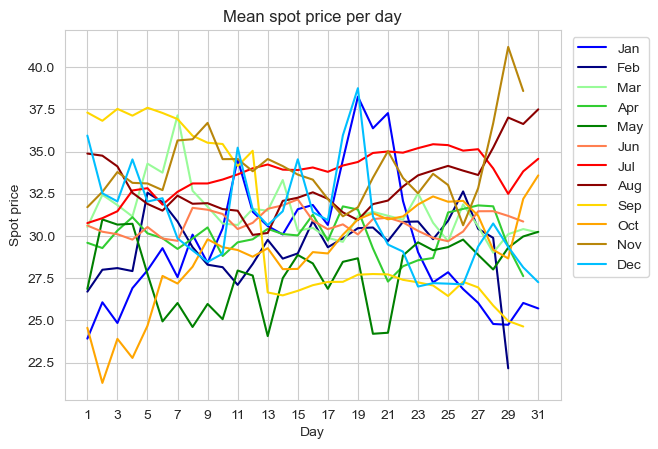

In [39]:
groups = ['month', 'day']
monthly_data = data[effects + groups].groupby(groups).mean()
for var in effects:
    plt.plot(monthly_data.loc[1][var], label='Jan', color='blue')
    plt.plot(monthly_data.loc[2][var], label='Feb', color='navy')
    plt.plot(monthly_data.loc[3][var], label='Mar', color='palegreen')
    plt.plot(monthly_data.loc[4][var], label='Apr', color='limegreen')
    plt.plot(monthly_data.loc[5][var], label='May', color='green')
    plt.plot(monthly_data.loc[6][var], label='Jun', color='coral')
    plt.plot(monthly_data.loc[7][var], label='Jul', color='red')
    plt.plot(monthly_data.loc[8][var], label='Aug', color='darkred')
    plt.plot(monthly_data.loc[9][var], label='Sep', color='gold')
    plt.plot(monthly_data.loc[10][var], label='Oct', color='orange')
    plt.plot(monthly_data.loc[11][var], label='Nov', color='darkgoldenrod')
    plt.plot(monthly_data.loc[12][var], label='Dec', color='deepskyblue')

    pretty_name = var.replace('_', ' ')
    plt.title(f'Mean {pretty_name} per day')
    plt.xlabel('Day')
    plt.xticks(range(1, 32, 2))
    plt.ylabel(pretty_name.capitalize())
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

# Granger Causality

In [40]:
granger_data = data.reset_index().drop(columns=['date', 'volume_production_rolling', 'volume_demand_rolling', 'target', 'rolling_mean_production', 'rolling_mean_demand', 'rolling_mean_spot_price'])

max_lag = 12
causes = granger_data.columns

In [41]:
warnings.filterwarnings('ignore')

In [42]:
causality_matrix = pd.DataFrame(np.ones((len(causes), len(effects))), index=causes, columns=effects)

for cause in causes:
    for effect in effects:
        if cause != effect:
            test_result = grangercausalitytests(granger_data[[effect, cause]], max_lag, verbose=False)
            causality_matrix[effect][cause] = min(test[0]['ssr_ftest'][1] for test in test_result.values())

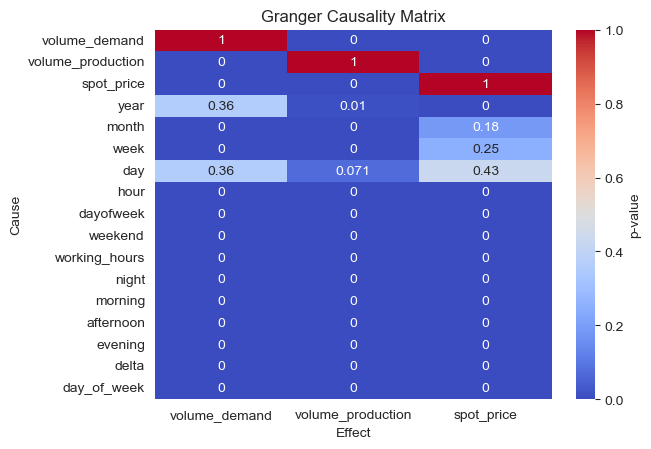

In [43]:
sns.heatmap(causality_matrix.round(5), annot=True, cmap='coolwarm', cbar_kws={'label': 'p-value'})
plt.title(f'Granger Causality Matrix')
plt.ylabel('Cause')
plt.xlabel('Effect')
plt.show()

In [ ]:
# TODO: analyze and improve

# Outlier detection

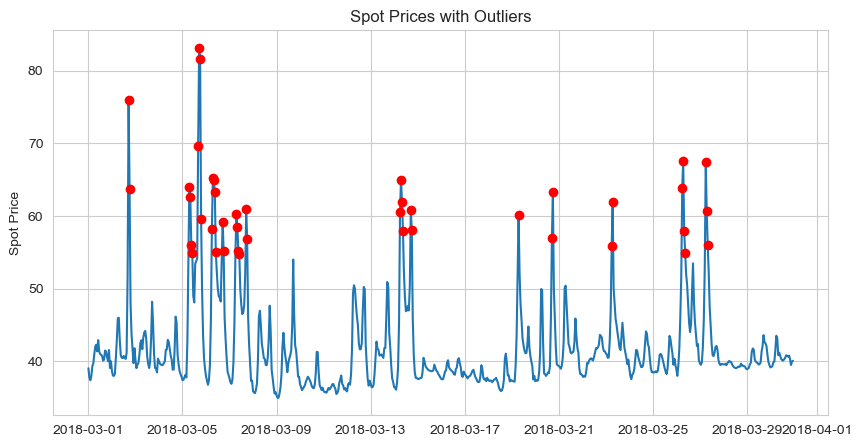

In [44]:
# calculate z-scores of one month of spot prices
data_month = data['spot_price'].loc['2018-03-01':'2018-03-30']
z_scores = zscore(data_month)
outliers = np.abs(z_scores) > 2

# plot spot prices with outliers
plt.figure(figsize=(10, 5))
plt.plot(data_month.index, data_month)
plt.plot(data_month.index[outliers], data_month[outliers], 'ro')
plt.title('Spot Prices with Outliers')
plt.ylabel('Spot Price')
plt.show()

# Stat models

ADF Statistic: -4.008970
p-value: 0.001364
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


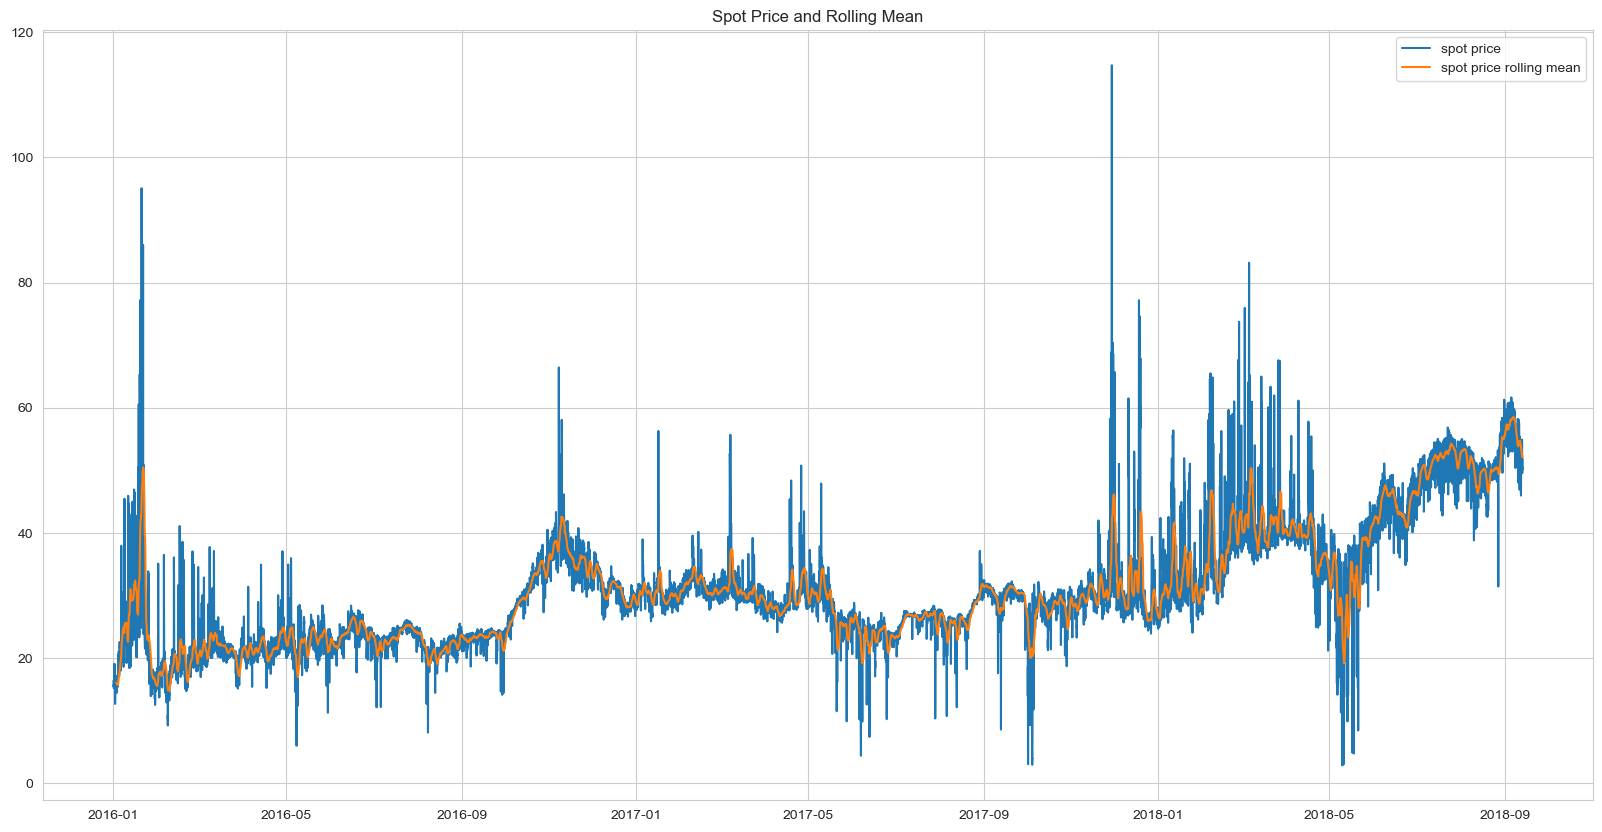

In [45]:
result = adfuller(data['spot_price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# create a rolling mean and rolling standard deviation
data['spot_price_rolling'] = data['spot_price'].rolling(window=48).mean()
data['spot_price_std'] = data['spot_price'].rolling(window=48).std()

# plot spot price and rolling mean
plt.figure(figsize=(20, 10))
plt.plot(data['spot_price'], label='spot price')
plt.plot(data['spot_price_rolling'], label='spot price rolling mean')
plt.title('Spot Price and Rolling Mean')
plt.legend()

# TODO: Summary